# Project Title

by Mariana Duarte, Ibrahim Jabarkhel, Edward Montoya

The goal of this project is to build a model that can successfully translate a foreign language into English. This project will demonstrate how an Attention model is superior to other types of models for Natural Language Processing (NLP). The most modest goal is training Attention and comparing it with other models:  LSTM, RNN, GRU. A goal that we hope to achieve is the implementation of an Attention model that can achieve a Bilingual Evaluation Understudy (BLEU) score of 60%. We are interested in this project because we will be using Attention which has become very popular in the last couple of years. We would like to gain experience and knowledge about this important Machine learning technique. In addition, we would like to explore why Attention performs better than other models.


## Load Data Set

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.ticker as ticker
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Embedding, LSTM, Dropout, BatchNormalization, RepeatVector, TimeDistributed, GRU, SimpleRNN, Layer
from keras.layers.wrappers import Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from unicodedata import normalize
from random import shuffle
from collections import Counter
import random  
import unicodedata
import re
import string
import numpy as np
import os
import io
import time

In [ ]:
# Downloading the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

file_path = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


## Prepare Data

In [ ]:
with open(file_path) as f:
    text = f.read()

Data with punctuations 

In [ ]:
lines = text.strip().split('\n')
text_split = [line.split('\t') for line in lines]
text_split[:10]

[['Go.', 'Ve.'],
 ['Go.', 'Vete.'],
 ['Go.', 'Vaya.'],
 ['Go.', 'Váyase.'],
 ['Hi.', 'Hola.'],
 ['Run!', '¡Corre!'],
 ['Run.', 'Corred.'],
 ['Who?', '¿Quién?'],
 ['Fire!', '¡Fuego!'],
 ['Fire!', '¡Incendio!']]

Printing the data from 100000 to 100005 with punctuations. 

In [ ]:
text_split[100000:100005]

[['Tom wants to sell everything in his garage.',
  'Tom quiere vender todo lo que hay en su cochera.'],
 ['Tom was alone when Mary and John walked in.',
  'Tom estaba solo cuando Mary y John entraron.'],
 ["Tom was disappointed in Mary's performance.",
  'Tom estaba decepcionado con el rendimiento de Mary.'],
 ['Tom was lying on the pier getting a suntan.',
  'Tom estaba recostado en el muelle bronceándose.'],
 ["Tom was married, but he didn't wear a ring.",
  'Tom era casado, pero no usaba anillo.']]

We cleaned up the data by doing the following:

*   Normalized to unicode characters
*   Tokenized on white space (split)
*   Converted all words to lowercase
*   Removed punctuation
*   Removed non-printable characters
*   Removed tokens with numbers in them

In [ ]:
def clean_text(lines):
  text_cleaned = []
  re_print = re.compile('[^%s]' % re.escape(string.printable))
  table = str.maketrans('', '', string.punctuation)

  for pair in lines:
    clean_pair = list()
    for line in pair:
      line = normalize('NFD', line).encode('ascii', 'ignore')
      line = line.decode('UTF-8')
      line = line.split()
      line = [word.lower() for word in line]
      line = [word.translate(table) for word in line]
      line = [re_print.sub('', w) for w in line]
      line = [word for word in line if word.isalpha()]
      clean_pair.append(' '.join(line))
    text_cleaned.append(clean_pair)
    
  return np.array(text_cleaned)

Visualizing the text after cleaning.

In [ ]:
text_cleaned = clean_text(text_split)
text_cleaned[:10]

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ['go', 'vayase'],
       ['hi', 'hola'],
       ['run', 'corre'],
       ['run', 'corred'],
       ['who', 'quien'],
       ['fire', 'fuego'],
       ['fire', 'incendio']], dtype='<U275')

In [ ]:
text_cleaned[100000:100005]

array([['tom wants to sell everything in his garage',
        'tom quiere vender todo lo que hay en su cochera'],
       ['tom was alone when mary and john walked in',
        'tom estaba solo cuando mary y john entraron'],
       ['tom was disappointed in marys performance',
        'tom estaba decepcionado con el rendimiento de mary'],
       ['tom was lying on the pier getting a suntan',
        'tom estaba recostado en el muelle bronceandose'],
       ['tom was married but he didnt wear a ring',
        'tom era casado pero no usaba anillo']], dtype='<U275')

The total amount of sentences in the dataset is 118,964 sentences.

In [ ]:
text_cleaned.shape

(118964, 2)

## Split the Data

We decided to use an offset of 40,000. We did this because the first 40,000 sentences are very short in length. After 40,000 the sentences exceed 5 words in length. We felt the use of longer sentences would benefit the use of an Attention model. Being that Attention performs well with longer sentences. 

Making this change required us to use less sentences. Originally, we could use 70,000 sentences, but because the sentences had increased in word size we were limited computationally to just using 50,000 sentences. The total amount of words for both approaches worked out to be about the same at around 300,000 English words, and 300,000 Spanish words total. 

In [ ]:
n_sentences = 50000 + 40000
dataset = text_cleaned[40000:n_sentences, :]

For the purposes of training we decided to do a train, test split of 80%. 

In [ ]:
# shuffle data set
shuffle(dataset)

# 80% of n_sentences
train, test = dataset[:40000], dataset[40000:]

Preprocess data


In [ ]:
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

Calculating the maximum number of tokens in sentence


In [ ]:
def max_length(lines):
  return max(len(line.split()) for line in lines)

Create tokenizer for English language.

Print the English vocabulary size, and word max length.

In [ ]:
# -------- English tokenizer ------------------
# Index 0 correlates to english
# Index 1 correlates to spanish
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab = len(eng_tokenizer.word_index) + 1
eng_len = max_length(dataset[:, 0])

print('English Vocabulary Size: %d' % eng_vocab)
print('English Max Length: %d' % (eng_len))

English Vocabulary Size: 6461
English Max Length: 10


Print the number of English words used for training, and testing. The amount of words is from 50,000 sentences.

In [ ]:
print('{} English words.'.format(len([word for sentence in dataset[:, 0] for word in sentence.split()])))

282334 English words.


Histogram of the top 10 words in the English dataset.

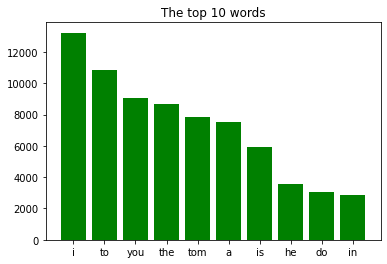

In [ ]:
# For Histogram
eng_words = eng_tokenizer.word_counts
counts = Counter(eng_words)
k = counts.most_common(10)

plt.bar([k[i][0] for i in range(10)], [k[i][1] for i in range(10)], color='g')
plt.title('The top 10 words')
plt.show()

Create tokenizer for Spanish language.

Print the Spanish vocabulary size, and word max length.

In [ ]:
# ---------- Spanish tokenizer ----------------
spa_tokenizer = create_tokenizer(dataset[:, 1])
spa_vocab = len(spa_tokenizer.word_index) + 1
spa_len = max_length(dataset[:, 1])

print('Spanish Vocabulary Size: %d' % spa_vocab)
print('Spanish Max Length: %d' % (spa_len))

Spanish Vocabulary Size: 10549
Spanish Max Length: 14


Print the number of Spanish words used for training, and testing. The amount of words is from 50,000 sentences.

In [ ]:
print('{} Spanish words.'.format(len([word for sentence in dataset[:, 1] for word in sentence.split()])))

269220 Spanish words.


Histogram of the top 10 words in the spanish dataset

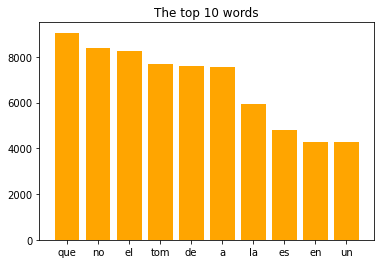

In [ ]:
spa_words = spa_tokenizer.word_counts
counts = Counter(spa_words)
j = counts.most_common(10)

plt.bar([j[i][0] for i in range(10)], [j[i][1] for i in range(10)], color='orange')
plt.title('The top 10 words')
plt.show()

Create Encoder

In [ ]:
# Encode Sequences
def encode_sequences(tokenizer, length, lines):
  X = tokenizer.texts_to_sequences(lines)
  X = pad_sequences(X, maxlen=length, padding='post')
  return X

Create Decoder

In [ ]:
# Encoder output
def encode_output(sequences, vocab_size):
  y = tf.one_hot(sequences, vocab_size)
  return y

In [ ]:
# Training data
train_x = encode_sequences(spa_tokenizer, spa_len, train[:, 1])
train_y = encode_sequences(eng_tokenizer, eng_len, train[:, 0])
train_y = encode_output(train_y, eng_vocab)

The encoder and decoder are super-efficient to translate sentences from one language to another language. The Spanish sentences are fed to the encoder, and the decoder outputs the English translation. Here the encode_sequences function is first creating a sequence of the text and creating a unique ID for each word. The pad_sequences is a similar concept of padding like in the Convolutional layer because each sentence length is different so by doing this will make a constant length for each sentence (which is the maximum length of sentence in the data). It will bring the ability to handle variable length input and output sequences of text without losing some words. The English translation should also be used as inputs to an encoder to create a seqToseq form.

The encode_output function which is actually a decoder, creates a one hot vector for the whole sentence by using full vocabulary words in the dataset. In other words, the size of these one hot vectors are the length of eng_vocab (which is 6464). 

In [ ]:
# Test data
test_x = encode_sequences(spa_tokenizer, spa_len, test[:, 1])
test_y = encode_sequences(eng_tokenizer, eng_len, test[:, 0])
test_y = encode_output(test_y, eng_vocab)

Visualizing the test data after encoding.

In [ ]:
test_x[0]

array([133,   1, 103,   9,   3,  63,   6,  25, 994,   0,   0,   0,   0,
         0], dtype=int32)

In [ ]:
test_y[0]

<tf.Tensor: shape=(10, 6461), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

## Metric for measuring models


We decided to use the most commonly accepted metric for testing machine language translation, which is the Bilingual Evaluation Understudy (BLEU). BLEU is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is" – this is the central idea behind BLEU.

In [ ]:
# Libraries needed
import nltk
import nltk.translate.bleu_score as bleu

import math
import numpy
import os

try:
  nltk.data.find('tokenizers/punkt')
except LookupError:
  nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def word_int(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

A function that allows us to input test_x, and it outputs a translation (prediction).

In [ ]:
def predict_sequence(model, tokenizer, value):
  prediction = model.predict(value, verbose=0)[0]
  integers = [np.argmax(vector) for vector in prediction]
  target = []
  for i in integers:
    word = word_int(i, tokenizer)
    if word is None:
      break
    target.append(word)
  return ' '.join(target)

BLEU_score was created as a way to provide a score for our models. The way that it works is that it takes a test_x sentence (test x validation), and uses the model to provide a translation (prediction), then that translation is compared against the corresponding test_y sentence (test y validation). The process of comparing is done by using the BLEU metric. 
 
Based on our understanding of how to compute a score for our models, we decided to use 3,000 sentences from our test sentences (validation) to provide an accurate measurement of the model. Basically, this process represents the process of providing input from a user that the model has never seen, and rendering a translation on this input. In this instance we have the solution already, and it allows us to score how well the translation was performed.

Note: The function required the use of using smoothing to provide an accurate score. BLEU was originally designed to provide Corpus scoring, and not individual sentence scoring. The smoothing allows for scoring to be done on a sentence-to-sentence basis.

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction

def BLEU_score(model):
  smoothie = SmoothingFunction().method2
  count = 0
  score_example = 0
  for i, value in enumerate(test_x):
    value = value.reshape((1, value.shape[0]))
    translation = predict_sequence(model, eng_tokenizer, value)
    _target, _src = test[i]
    if i < 3000:
      #count += 1
      translation = str(translation).split()
      _target = str(_target).split()
      new_score = bleu.sentence_bleu([translation], _target, smoothing_function=smoothie)
      if (new_score > 0):
        count += 1
        score_example += new_score
    elif i > 3000:
      break
  final_score = score_example/count
  return final_score

A simple function that provides visual translations. Similar to the BLEU_score function, it compares the translation of (test_x) to (test_y), but it prints it out for the human eye to see.

In [ ]:
def visualize_translation(model, numOfLines):
  for i, value in enumerate(test_x):
    value = value.reshape((1, value.shape[0]))
    translation = predict_sequence(model, eng_tokenizer, value)
    _target, _src = test[i]
    if i < numOfLines:
      print('Target=[%s], Prediction[%s]' % (_target, translation))
    elif i > numOfLines+1:
      break

In [ ]:
# For repeatability
random.seed(0) 

## Build RNN model

In [ ]:
embeded_size = 150

model1 = Sequential()

model1.add(Embedding(spa_vocab, embeded_size, input_length=spa_len))
model1.add(BatchNormalization())
model1.add(SimpleRNN(300))
model1.add(BatchNormalization())
model1.add(RepeatVector(eng_len))
model1.add(Bidirectional(SimpleRNN(300, return_sequences=True)))
model1.add(BatchNormalization())
model1.add(TimeDistributed(Dense(eng_vocab, activation='softmax')))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 150)           1582350   
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 150)           600       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 300)               135300    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 600)           360600    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 600)           2

The baseline RNN model is a Sequential model which is prepared to train in two different languages. The first layer "Embedding" is converting the word represented with the ID into embedding. It's a classification model. The RNN model tends to do poorly because it has the vanishing gradient problem. Batch Normalization is used to rescale the data effictively, normally used insead of Droupout. The repeat_vector layer repeats the inputs n times which influences the shape of input data. Lastly, using 'softmax' as an activation. 

When constructing this model we tried using numerous layers but it would overfit early on, so we settled with a simple RNN model with not a lot of layers.

### Train RNN

In [ ]:
model1.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history1 = model1.fit(train_x, 
                    train_y, 
                    epochs=30, 
                    batch_size=32, 
                    validation_data=(test_x, test_y))

Epoch 1/30
1250/1250 [==============================] - 45s 33ms/step - loss: 4.2377 - accuracy: 0.4422 - val_loss: 3.9239 - val_accuracy: 0.4170
Epoch 2/30
1250/1250 [==============================] - 39s 31ms/step - loss: 3.1866 - accuracy: 0.4938 - val_loss: 3.6977 - val_accuracy: 0.4379
Epoch 3/30
1250/1250 [==============================] - 39s 31ms/step - loss: 2.9095 - accuracy: 0.5099 - val_loss: 15.9961 - val_accuracy: 0.0020
Epoch 4/30
1250/1250 [==============================] - 40s 32ms/step - loss: 2.9438 - accuracy: 0.5060 - val_loss: 3.5573 - val_accuracy: 0.4461
Epoch 5/30
1250/1250 [==============================] - 40s 32ms/step - loss: 2.7854 - accuracy: 0.5135 - val_loss: 3.5001 - val_accuracy: 0.4521
Epoch 6/30
1250/1250 [==============================] - 38s 31ms/step - loss: 2.6292 - accuracy: 0.5248 - val_loss: 3.4298 - val_accuracy: 0.4626
Epoch 7/30
1250/1250 [==============================] - 39s 31ms/step - loss: 2.5104 - accuracy: 0.5345 - val_loss: 3.4255 

### Plot loss and accuracy

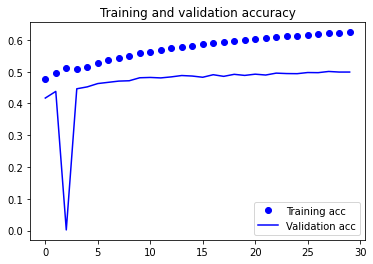

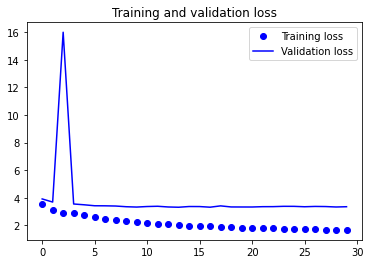

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

From the plots of 'Training and validation loss' we can conclude that the model is training well. Although in the beginning it decreases, it looks like there is minimal overfitting with the validation loss because it decreases to a point and begins increasing again, but it is not a huge decrease.

### Test RNN translation output

In [ ]:
score1 = BLEU_score(model1)
print('BLEU score for model: {:.2f}'.format(score1))

BLEU score for model: 0.28


Here we can visualize some translations of how the RNN model performed.


In [ ]:
visualize_translation(model1, 40)

Target=[we have to be at work by nine], Prediction[i have to to to by book nine]
Target=[its just your imagination], Prediction[its only dangerous]
Target=[i dont want to see you here again], Prediction[i dont want to go to]
Target=[hes a doctor of good reputation], Prediction[its a same year untouched]
Target=[it looks like mary is drunk again], Prediction[i not to to to]
Target=[tom also has plans to go there], Prediction[tom seems to be be]
Target=[i did nothing during the holidays], Prediction[i dont you your of]
Target=[the plane arrived exactly at nine], Prediction[the rain exploded five days]
Target=[you must think this is funny], Prediction[what dont of if its hot]
Target=[he claims that he is a painter], Prediction[i think its to neat good]
Target=[i need to get something for tom], Prediction[i i to to to]
Target=[one of the girls was left behind], Prediction[james madison the than trees]
Target=[whats your favorite number], Prediction[whats your favorite web]
Target=[tom hasn


##Build LSTM model

In [ ]:
embeded_size = 150

model2 = Sequential()
model2.add(Embedding(spa_vocab, embeded_size, input_length=spa_len))
model2.add(BatchNormalization())
model2.add(LSTM(256))
model2.add(BatchNormalization())
model2.add(RepeatVector(eng_len))
model2.add(LSTM(256))
model2.add(BatchNormalization())
model2.add(RepeatVector(eng_len))
model2.add(LSTM(256, return_sequences=True, dropout=0.2))
model2.add(TimeDistributed(Dense(eng_vocab, activation="softmax")))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 150)           1582350   
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 150)           600       
_________________________________________________________________
lstm (LSTM)                  (None, 256)               416768    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)              

The LSTM model is based on the Sequential model which is prepared to train in two different languages and to translate from one language to another. The LSTM model is a "Long Short Term Memory network" and best defined as capable of learning long-term dependencies. LSTM is considered to be better than RNN because it has been proposed to solve the vanishing gradient problem that RNN doesn't. The first layer "Embedding" is converting the word represented with the ID into embedding. It will map similar words into one region during the training which means it's using a classification model.  In this model the LSTM layer will learn the translation by receiving the mapped word2vec data from the embedding layer. Batch Normalization is used to rescale the data effectively, "this operation lets the model learn the optimal scale and mean of each of the layer’s inputs." If we add the Batch Normalization layer, then no need to scale and standardize the data. The repeat_vector layer repeats the inputs n times which is beneficial in using some layers multiple times that affect the shape of input data. 

### Train LSTM

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy',
 metrics=['accuracy'])
history2 = model2.fit(train_x, 
                    train_y, 
                    epochs=30, 
                    batch_size=32, 
                    validation_data=(test_x, test_y))

Epoch 1/30
1250/1250 [==============================] - 36s 23ms/step - loss: 4.0979 - accuracy: 0.4599 - val_loss: 4.0452 - val_accuracy: 0.4265
Epoch 2/30
1250/1250 [==============================] - 28s 22ms/step - loss: 3.3228 - accuracy: 0.4898 - val_loss: 3.9143 - val_accuracy: 0.4286
Epoch 3/30
1250/1250 [==============================] - 28s 22ms/step - loss: 3.1675 - accuracy: 0.4978 - val_loss: 3.6469 - val_accuracy: 0.4389
Epoch 4/30
1250/1250 [==============================] - 28s 22ms/step - loss: 3.0408 - accuracy: 0.5046 - val_loss: 3.7505 - val_accuracy: 0.4362
Epoch 5/30
1250/1250 [==============================] - 28s 22ms/step - loss: 2.9582 - accuracy: 0.5097 - val_loss: 3.4437 - val_accuracy: 0.4615
Epoch 6/30
1250/1250 [==============================] - 27s 22ms/step - loss: 2.7683 - accuracy: 0.5254 - val_loss: 3.6586 - val_accuracy: 0.4478
Epoch 7/30
1250/1250 [==============================] - 28s 22ms/step - loss: 2.6808 - accuracy: 0.5314 - val_loss: 3.3735 -

### Plot loss and accuracy

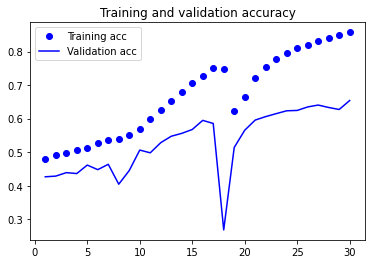

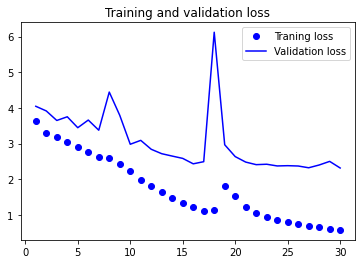

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Traning loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure();

The plots are comparing training accuracy with validation accuracy and training loss with validation loss. The plots are normal and are trained well because the loss is coming down and the accuracy is increasing with the number of epoch. However, the huge downfall in validation accuracy and the spike in validation loss around 17 epoch is because of seeing a longer sentence which is not seen before. It is different each time we run the notebook because we are shuffling the data. It's not usually like this.

### Test LSTM translation output

In [ ]:
score2 = BLEU_score(model2)
print('BLEU score for model: {:.2f}'.format(score2))

BLEU score for model: 0.45


In [ ]:
# Visualize some translations
visualize_translation(model2, 40)

Target=[we have to be at work by nine], Prediction[we have to get home home nine]
Target=[its just your imagination], Prediction[its only your your]
Target=[i dont want to see you here again], Prediction[i dont want to see you again]
Target=[hes a doctor of good reputation], Prediction[its is doctor a strange]
Target=[it looks like mary is drunk again], Prediction[i said tom was in]
Target=[tom also has plans to go there], Prediction[tom has to go to go there]
Target=[i did nothing during the holidays], Prediction[i didnt sleep tom on]
Target=[the plane arrived exactly at nine], Prediction[the plane came closed at ten]
Target=[you must think this is funny], Prediction[you must think tom is funny]
Target=[he claims that he is a painter], Prediction[speaking is the is is]
Target=[i need to get something for tom], Prediction[i need to ask tom tom]
Target=[one of the girls was left behind], Prediction[a of were grow at]
Target=[whats your favorite number], Prediction[whats your favorite pa

##Build GRU model

In [ ]:
embeded_size = 150

model3 = Sequential()

model3.add(Embedding(spa_vocab, embeded_size, input_length=spa_len))
model3.add(GRU(300))
model3.add(BatchNormalization())
model3.add(RepeatVector(eng_len))
model3.add(Bidirectional(GRU(200, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))))
model3.add(BatchNormalization())
model3.add(TimeDistributed(Dense(eng_vocab, activation='softmax')))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 14, 150)           1582350   
_________________________________________________________________
gru (GRU)                    (None, 300)               406800    
_________________________________________________________________
batch_normalization_6 (Batch (None, 300)               1200      
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 10, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 400)           602400    
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 400)           1600      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 6461)         

The GRU model is a Sequential model, the first layer "Embedding" is converting the word represented with the ID into embedding. The third layer is Batch Normalization; it is used to rescale the data effectively, normally used instead of Dropout. The repeat_vector layer repeats the inputs n times which influences the shape of input data. In the Bidirectional layer, we used regularizers norm L2. Lastly, using 'softmax' as an activation. 
 
When constructing this model we tried using Dropout because it would overfit early on, but when using dropout the model would lose data that needed to train on. So we used a regularizer norm L2 to help with the overfitting, which provided better results. 

###Train GRU

In this moodel we're using earlystopping to monitor 'val_loss' with patience of 5.

In [ ]:
model3.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]


history3 = model3.fit(train_x, 
                    train_y, 
                    epochs=30, 
                    batch_size=32,
                    callbacks = callbacks,
                    validation_data=(test_x, test_y))

Epoch 1/30
1250/1250 [==============================] - 34s 24ms/step - loss: 3.6204 - accuracy: 0.5082 - val_loss: 3.0606 - val_accuracy: 0.5184
Epoch 2/30
1250/1250 [==============================] - 29s 23ms/step - loss: 1.6985 - accuracy: 0.6598 - val_loss: 2.2271 - val_accuracy: 0.6062
Epoch 3/30
1250/1250 [==============================] - 29s 23ms/step - loss: 1.0825 - accuracy: 0.7503 - val_loss: 1.9792 - val_accuracy: 0.6479
Epoch 4/30
1250/1250 [==============================] - 28s 23ms/step - loss: 0.8118 - accuracy: 0.8055 - val_loss: 1.9326 - val_accuracy: 0.6736
Epoch 5/30
1250/1250 [==============================] - 29s 23ms/step - loss: 0.6461 - accuracy: 0.8433 - val_loss: 1.9213 - val_accuracy: 0.6835
Epoch 6/30
1250/1250 [==============================] - 28s 23ms/step - loss: 0.5417 - accuracy: 0.8689 - val_loss: 1.9284 - val_accuracy: 0.6987
Epoch 7/30
1250/1250 [==============================] - 29s 23ms/step - loss: 0.4769 - accuracy: 0.8847 - val_loss: 1.9630 -

###Plot loss and Accuracy 

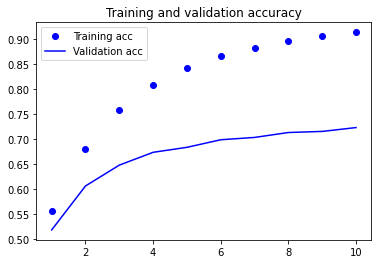

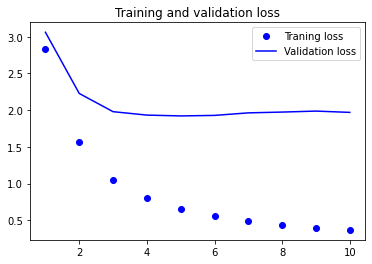

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Traning loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure();

From the plots of 'Training and validation loss' we can conclude that the model is training poorly. It looks like there is some overfitting with the validation loss because it decreases to a point and begins increasing again, but it is not a huge decrease. Most telling is that the training and validation loss are visually separating. 

### Test GRU translation output

In [ ]:
score3 = BLEU_score(model3)
print('BLEU score for model: {:.2f}'.format(score3))

BLEU score for model: 0.55


In [ ]:
visualize_translation(model3, 40)

Target=[we have to be at work by nine], Prediction[we have to get at at at nine]
Target=[its just your imagination], Prediction[its only your imagination]
Target=[i dont want to see you here again], Prediction[i dont want to see you early]
Target=[hes a doctor of good reputation], Prediction[he the doctor of good reputation reputation]
Target=[it looks like mary is drunk again], Prediction[this looks that is understand over]
Target=[tom also has plans to go there], Prediction[tom has has go to go there]
Target=[i did nothing during the holidays], Prediction[i didnt let it on]
Target=[the plane arrived exactly at nine], Prediction[the plane came at at nine]
Target=[you must think this is funny], Prediction[you must think this is funny]
Target=[he claims that he is a painter], Prediction[he said he to a a]
Target=[i need to get something for tom], Prediction[i need something to tom tom]
Target=[one of the girls was left behind], Prediction[one leave the girls was was behind]
Target=[what

## Build Additive Attention model

In [ ]:
pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.47.0-cp36-none-any.whl size=17290 sha256=e965646b47bebc6335078ffcc3ead37bcddf6a5efdd48828aa7ce0e014f8c00d
  Stored in directory: /root/.cache/pip/wheels/70/87/01/76c703d5401b65e323927c1fdc665f3fb143282ff67d71e859
Successfully built keras-self-attention


In [ ]:
from keras_self_attention import SeqSelfAttention

In [ ]:
#  Bahdanau // Additive
embeded_size = 150

model4 = Sequential()

model4.add(Embedding(spa_vocab, embeded_size, input_length=spa_len))
model4.add(BatchNormalization())
model4.add(LSTM(300))
model4.add(BatchNormalization())
model4.add(RepeatVector(eng_len))
model4.add(SeqSelfAttention(attention_activation='sigmoid'))
model4.add(Bidirectional(LSTM(300, return_sequences=True)))
model4.add(BatchNormalization())
model4.add(TimeDistributed(Dense(eng_vocab, activation='softmax')))

In [ ]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 14, 150)           1582350   
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 150)           600       
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               541200    
_________________________________________________________________
batch_normalization_9 (Batch (None, 300)               1200      
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 10, 300)           0         
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 300)         19265     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 600)        

For our first approach with using an Attention model we decided to use the attention mechanism introduced by Bahdanau (Additive Attention). This approach was the first attention mechanism to exist. It works by giving the decoder a way to “pay attention” to parts of the input, rather than relying on a single vector. Basically, for every step in the decoder process the attention can select a different part of the input sentence to consider. 
 
We found it very difficult in trying to implement attention into a model. Most of the examples that existed were constructed with non-sequential models. A lot of time was spent trying to figure out a way to make this approach possible. We ended up finding a source that provides a means to implement attention in a sequential manner. 
 
Source: https://github.com/CyberZHG/keras-self-attention

### Train model

In [ ]:
model4.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
%%time
history4 = model4.fit(train_x, 
                    train_y, 
                    epochs=30, 
                    batch_size=32, 
                    validation_data=(test_x, test_y))

Epoch 1/30
1250/1250 [==============================] - 36s 26ms/step - loss: 3.2637 - accuracy: 0.5223 - val_loss: 3.3188 - val_accuracy: 0.4605
Epoch 2/30
1250/1250 [==============================] - 31s 25ms/step - loss: 1.3383 - accuracy: 0.6946 - val_loss: 2.0639 - val_accuracy: 0.6189
Epoch 3/30
1250/1250 [==============================] - 31s 25ms/step - loss: 0.8073 - accuracy: 0.7921 - val_loss: 1.9725 - val_accuracy: 0.6557
Epoch 4/30
1250/1250 [==============================] - 31s 25ms/step - loss: 0.5603 - accuracy: 0.8494 - val_loss: 1.8334 - val_accuracy: 0.6847
Epoch 5/30
1250/1250 [==============================] - 31s 25ms/step - loss: 0.4080 - accuracy: 0.8882 - val_loss: 1.8660 - val_accuracy: 0.6985
Epoch 6/30
1250/1250 [==============================] - 31s 25ms/step - loss: 0.3130 - accuracy: 0.9132 - val_loss: 1.8987 - val_accuracy: 0.7169
Epoch 7/30
1250/1250 [==============================] - 31s 25ms/step - loss: 0.2560 - accuracy: 0.9277 - val_loss: 2.0034 -

### Plot loss and accuracy

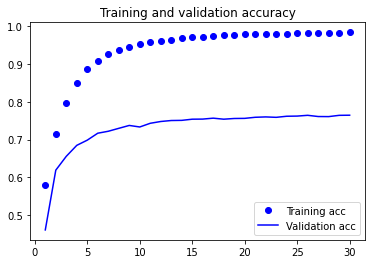

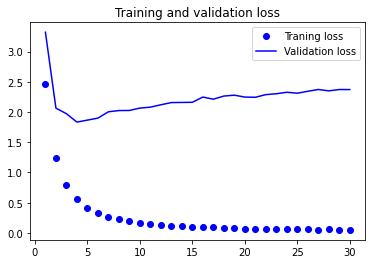

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Traning loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure();

After conducting many tests we felt that the perfect amount of epochs was 30. This allowed us to achieve high BLEU scores, but also limit the amount of overfitting. We noticed that overfitting was not necessarily indicative of poor translations. Although, if we tried to train for over 50 epochs, then overfitting would indeed adversely affect the BLEU score. So overfitting was okay to some degree. 

### Test Attention translation output

In [ ]:
score4 = BLEU_score(model4)
print('BLEU score for model: {:.2f}'.format(score4))

BLEU score for model: 0.65


In [ ]:
# Visualize some translations
visualize_translation(model4, 40)

Target=[we have to be at work by nine], Prediction[we have to be at work by nine]
Target=[its just your imagination], Prediction[its only your imagination]
Target=[i dont want to see you here again], Prediction[i dont want to see you again]
Target=[hes a doctor of good reputation], Prediction[hes a doctor of good reputation]
Target=[it looks like mary is drunk again], Prediction[it seems that shes is again]
Target=[tom also has plans to go there], Prediction[tom also has plans to go there go]
Target=[i did nothing during the holidays], Prediction[i didnt grow in on face]
Target=[the plane arrived exactly at nine], Prediction[the plane hid exactly at]
Target=[you must think this is funny], Prediction[you must think this is funny]
Target=[he claims that he is a painter], Prediction[he claims that he is a]
Target=[i need to get something for tom], Prediction[i need to hear tom something]
Target=[one of the girls was left behind], Prediction[one of the girls was left behind]
Target=[whats 

## Build Multiplicative Attention Model

In [ ]:
import keras.regularizers 

embeded_size = 150

model5 = Sequential()

model5.add(Embedding(spa_vocab, embeded_size, input_length=spa_len))
model5.add(BatchNormalization())
model5.add(Bidirectional(LSTM(300)))
model5.add(BatchNormalization())
model5.add(RepeatVector(eng_len))
model5.add(SeqSelfAttention(attention_width=10,
                           attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                           attention_activation=None,
                           kernel_regularizer=keras.regularizers.l2(1e-6),
                           bias_regularizer=keras.regularizers.l1(1e-6),
                           attention_regularizer_weight=1e-6,
                           use_attention_bias=False,
                           name='Attention',))
model5.add(Bidirectional(LSTM(300, return_sequences=True)))
model5.add(BatchNormalization())
model5.add(TimeDistributed(Dense(eng_vocab, activation='softmax')))

In [ ]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 14, 150)           1582350   
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 150)           600       
_________________________________________________________________
bidirectional_3 (Bidirection (None, 600)               1082400   
_________________________________________________________________
batch_normalization_12 (Batc (None, 600)               2400      
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 10, 600)           0         
_________________________________________________________________
Attention (SeqSelfAttention) (None, 10, 600)           360000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 10, 600)          

For our last model we decided to try and achieve the best possible BLEU score. We decided to implement a Multiplicative Attention model, which was originally introduced by Luong et al. The main difference is the attention calculation relies on the target (decoder) side hidden state and corresponding source (encode) side state, normalized over all states to get values summing to 1. This method is often referred to as a dot product between the states. The hidden states for the encoder/source, and the hidden states for the decoder/target. 

In [ ]:
model5.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
history5 = model5.fit(train_x, 
                    train_y, 
                    epochs=30, 
                    batch_size=32, 
                    validation_data=(test_x, test_y))

Epoch 1/30
1250/1250 [==============================] - 42s 29ms/step - loss: 3.1618 - accuracy: 0.5444 - val_loss: 2.2820 - val_accuracy: 0.5821
Epoch 2/30
1250/1250 [==============================] - 34s 27ms/step - loss: 1.0659 - accuracy: 0.7395 - val_loss: 1.9073 - val_accuracy: 0.6471
Epoch 3/30
1250/1250 [==============================] - 34s 27ms/step - loss: 0.6397 - accuracy: 0.8277 - val_loss: 1.8630 - val_accuracy: 0.6888
Epoch 4/30
1250/1250 [==============================] - 34s 27ms/step - loss: 0.4362 - accuracy: 0.8787 - val_loss: 1.7984 - val_accuracy: 0.7119
Epoch 5/30
1250/1250 [==============================] - 35s 28ms/step - loss: 0.3297 - accuracy: 0.9083 - val_loss: 1.8614 - val_accuracy: 0.7230
Epoch 6/30
1250/1250 [==============================] - 34s 27ms/step - loss: 0.2569 - accuracy: 0.9287 - val_loss: 1.9864 - val_accuracy: 0.7324
Epoch 7/30
1250/1250 [==============================] - 34s 27ms/step - loss: 0.2124 - accuracy: 0.9415 - val_loss: 1.9155 -

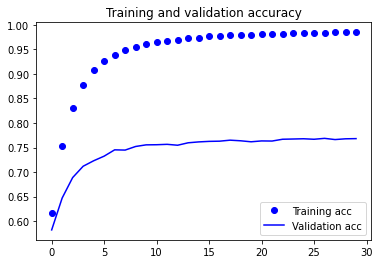

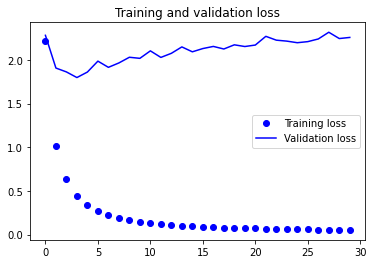

In [ ]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
score5 = BLEU_score(model5)
print('BLEU score for model: {:.2f}'.format(score5))

BLEU score for model: 0.65


In [ ]:
visualize_translation(model5, 40)

Target=[we have to be at work by nine], Prediction[we have to be at work by nine]
Target=[its just your imagination], Prediction[its just your imagination]
Target=[i dont want to see you here again], Prediction[i dont want to see you again]
Target=[hes a doctor of good reputation], Prediction[hes a doctor of good reputation]
Target=[it looks like mary is drunk again], Prediction[it think that alone alone again]
Target=[tom also has plans to go there], Prediction[tom also has plans to go there]
Target=[i did nothing during the holidays], Prediction[i didnt do anything on saturday]
Target=[the plane arrived exactly at nine], Prediction[the plane came at at nine]
Target=[you must think this is funny], Prediction[you must think this is funny]
Target=[he claims that he is a painter], Prediction[he say that is not a]
Target=[i need to get something for tom], Prediction[i need something need tom]
Target=[one of the girls was left behind], Prediction[one of girls girls was left behind]
Target=

## Compare / Contrast models 

In [ ]:
# Print acc / val_acc / bleu / translations
models = [model1, model2, model3, model4, model5]
scores = [score1, score2, score3, score4, score5]
histories = [history1, history2, history3, history4, history5]

i=0
for score, history, model in zip(scores, histories, models):
  if (i==0):
    print('-----------Results for RNN Model-----------')
  elif (i==1):
    print('-----------Results for LSTM Model-----------')
  elif (i==2):
    print('-----------Results for GRU Model-----------')
  elif (i==3):
    print('-----------Results for Bahdanau/Additive Attention Model-----------')
  elif (i==4):
    print('-----------Results for Luong/Multiplicative Attention Model-----------')
  print('BLEU Score: {:.2f}'.format(score))
  print('Accuracy: {:.2f}'.format(history.history['accuracy'][-1]))
  print('Validation Accuracy: {:.2f}'.format(history.history['val_accuracy'][-1]))
  print('\nPredictions:')
  visualize_translation(model, 20)
  print('\n' * 3)
  i = i + 1

-----------Results for RNN Model-----------
BLEU Score: 0.28
Accuracy: 0.62
Validation Accuracy: 0.50

Predictions:
Target=[we have to be at work by nine], Prediction[i have to to to by book nine]
Target=[its just your imagination], Prediction[its only dangerous]
Target=[i dont want to see you here again], Prediction[i dont want to go to]
Target=[hes a doctor of good reputation], Prediction[its a same year untouched]
Target=[it looks like mary is drunk again], Prediction[i not to to to]
Target=[tom also has plans to go there], Prediction[tom seems to be be]
Target=[i did nothing during the holidays], Prediction[i dont you your of]
Target=[the plane arrived exactly at nine], Prediction[the rain exploded five days]
Target=[you must think this is funny], Prediction[what dont of if its hot]
Target=[he claims that he is a painter], Prediction[i think its to neat good]
Target=[i need to get something for tom], Prediction[i i to to to]
Target=[one of the girls was left behind], Prediction[jam

## Conclusion

Looking into all the results of five models, the Multiplicative Attention Model is better in terms of validation accuracy, blue score, and actual prediction. RNN is the worst because the gradient for the RNN model becomes very hard when the length of the sentences gets increased. RNN faces gradient vanishing problem with the lengthy sentences. We observed during optimizing the models that even RNN, LSTM, and GRU were doing pretty well with just a few words translation, but LSTM and GRU always outperformed RNN in Neural Machine Translation. The highest blue score we got for the Multiplicative Attention Model was 0.71, but it was difficult to produce this as our final score because every time we ran the notebook the data would shuffle. 